In [8]:
import os
import matplotlib.pyplot as plt
import math
import cv2
import numpy as np

In [39]:
sources_coordinates_file = open('sources_pixels.txt', 'r')
sources_coordinates_lines = sources_coordinates_file.readlines()

#line2 = sources_coordinates_lines[2].split(",")
#print(line2[2])

In [40]:
import re
data_path = '/var/tmp/zapp_an-a/Desktop/gamma_sources_identification/CNN_project/ann_gray_stretch_dataset'
# ASSUMING WE ARE DOING BINARY CLASSIFICATION
def load_data():
    # let's put directly images inside these arrays and not only image paths
    x_train = []
    y_train_class = []
    y_train_loc = []
    x_test = []
    y_test_class = []
    y_test_loc = []

    train_bkg_count = 0
    train_src_count = 0

    for img_name in os.listdir(data_path):
        img_full_path = data_path + '/' + img_name
        #print(img_full_path)
        image = cv2.imread(img_full_path)
        image = cv2.pyrDown(image)
        #image = cv2.pyrDown(image)
        if img_name[0] == 'B': #background image
            if train_bkg_count < 800: # append in training set
                x_train.append(image)
                y_train_class.append(0)
                y_train_loc.append((0, 0))
                #y_train.append((0, (0, 0)))  # None for background images
                train_bkg_count += 1
            else: # append in test set
                x_test.append(image)
                y_test_class.append(0)
                y_test_loc.append((0,0))
                #y_test.append((0, (0, 0)))
        else: #source image
            img_index = int(re.findall('\d+', img_name )[0])
            source_x = int(float(sources_coordinates_lines[img_index].split(",")[1]))
            source_y = int(float(sources_coordinates_lines[img_index].split(",")[2]))
            source_coordinates = (source_x, source_y)
            
            if train_src_count < 800:
                x_train.append(image)
                y_train_class.append(1)
                y_train_loc.append(source_coordinates)
                train_src_count += 1
            else: # append in test set
                x_test.append(image)
                y_test_class.append(1)
                y_test_loc.append(source_coordinates)
                train_src_count += 1

    x_train = np.array(x_train)
    y_train_class = np.array(y_train_class)
    y_train_loc = np.array(y_train_loc)
    x_test = np.array(x_test)
    y_test_class = np.array(y_test_class)
    y_test_loc = np.array(y_test_loc)
    
    #return (x_train, y_train), (x_test, y_test)
    return (x_train, y_train_class, y_train_loc), (x_test, y_test_class, y_test_loc)

In [41]:
#(x_train, y_train), (x_test, y_test) = load_data()
(x_train, y_train_class, y_train_loc), (x_test, y_test_class, y_test_loc) = load_data()

In [42]:
#print(x_train.shape)
#print(y_train.shape)
#print(x_test.shape)
#print(y_test.shape)

print(x_train.shape)
print(y_train_class.shape)
print(y_train_loc.shape)
print(x_test.shape)
print(y_test_class.shape)
print(y_test_loc.shape)

(1600, 250, 250, 3)
(1600,)
(1600, 2)
(400, 250, 250, 3)
(400,)
(400, 2)


In [ ]:
# ok so we have the whole loaded dataset. Each image is of course made of 3 channels. Let's see how a
# possible CNN behave

In [43]:
# Normalization
x_train = x_train / 255
x_test = x_test / 255

In [77]:
# BUILING THE CONVOLUTIONAL NEURAL NETWORKS

In [44]:
import tensorflow as tf
from tensorflow import keras

In [45]:
# Assuming num_of_classes is defined earlier in your code
num_of_classes = 2

# Input layer
input_layer = keras.layers.Input(shape=(250, 250, 3))

# Convolutional layers
conv1 = keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu')(input_layer)
pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu')(pool1)
pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu')(pool2)
pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

# Flatten and further dense layers
flatten = keras.layers.Flatten()(pool3)

dense1 = keras.layers.Dense(128, activation='relu')(flatten)
dropout1 = keras.layers.Dropout(0.5)(dense1)

# Separate output branches
class_output = keras.layers.Dense(num_of_classes, activation='sigmoid', name='class_output')(dropout1)
coord_output = keras.layers.Dense(2, activation='linear', name='coord_output')(dropout1)

# Define the model
model = keras.Model(inputs=input_layer, outputs=[class_output, coord_output])

In [46]:
model.compile(optimizer='adam',
              loss={'class_output': 'sparse_categorical_crossentropy', 'coord_output': 'mean_squared_error'},
              loss_weights={'class_output': 1.0, 'coord_output': 1.0},
              metrics={'class_output': 'accuracy', 'coord_output': 'mae'})

In [ ]:
# training the neural network
#history = model.fit(x_train, y_train, validation_split=0.1, epochs=10)
#few epochs for avoiding overtraining

history = model.fit(x_train, {'class_output': y_train_class, 'coord_output': y_train_loc},
                    validation_split=0.1,
                    epochs=20) #+10

Epoch 1/20
45/45 [==============================] - 18s 398ms/step - loss: 9651.9277 - class_output_loss: 1.1870 - coord_output_loss: 9650.7402 - class_output_accuracy: 0.8056 - coord_output_mae: 67.8360 - val_loss: 22586.2246 - val_class_output_loss: 0.5974 - val_coord_output_loss: 22585.6289 - val_class_output_accuracy: 0.7750 - val_coord_output_mae: 113.4059
Epoch 2/20
45/45 [==============================] - 18s 393ms/step - loss: 9484.8281 - class_output_loss: 1.1114 - coord_output_loss: 9483.7178 - class_output_accuracy: 0.7715 - coord_output_mae: 67.5871 - val_loss: 17179.8105 - val_class_output_loss: 0.2490 - val_coord_output_loss: 17179.5625 - val_class_output_accuracy: 0.8438 - val_coord_output_mae: 96.4227
Epoch 3/20
45/45 [==============================] - 18s 393ms/step - loss: 8363.2676 - class_output_loss: 1.1296 - coord_output_loss: 8362.1387 - class_output_accuracy: 0.7424 - coord_output_mae: 63.5651 - val_loss: 18696.1250 - val_class_output_loss: 0.2488 - val_coord_ou

In [48]:
results = model.evaluate(x_test, {'class_output': y_test_class, 'coord_output': y_test_loc})
total_loss = results[0]
class_loss = results[1]  # Loss for the classification output
coord_loss = results[2]  # Loss for the coordinate output
class_accuracy = results[3]  # Accuracy for the classification output
coord_mae = results[4]  # MAE for the coordinate output

print('Total Loss =', total_loss)
print('Classification Loss =', class_loss)
print('Coordinate Loss =', coord_loss)
print('Classification Accuracy =', class_accuracy)
print('Coordinate MAE =', coord_mae)


13/13 [==============================] - 1s 98ms/step - loss: 9798.4541 - class_output_loss: 1.4341 - coord_output_loss: 9797.0205 - class_output_accuracy: 0.7825 - coord_output_mae: 68.9468
Total Loss = 9798.4541015625
Classification Loss = 1.434139370918274
Coordinate Loss = 9797.0205078125
Classification Accuracy = 0.7825000286102295
Coordinate MAE = 68.94676971435547


1/1 [==============================] - 0s 18ms/step
1 [214.77422 221.5334 ]


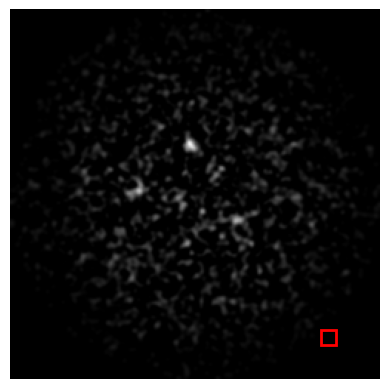

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assuming you have the model predictions for a test image
test_image_index = 300# Change this to the index of the test image you want to visualize
test_image = x_test[test_image_index]
class_predictions, coord_predictions = model.predict(np.expand_dims(test_image, axis=0))


# Extract predicted class and coordinates
predicted_class = np.argmax(class_predictions)
predicted_coords = coord_predictions[0]
print(predicted_class, predicted_coords)

# Display the test image
plt.imshow(test_image)
plt.axis('off')

# Add bounding box if source is predicted
if predicted_class == 1:
    x, y = predicted_coords  # Adjust coordinates according to your format
    width = height = 10  # Adjust these values according to your desired box size
    rect = patches.Rectangle((x - width/2, y - height/2), width, height, linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

plt.show()
